In [6]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import os
import gc
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#Load the data and make new df
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [8]:
def complete_col(train,test,col):
    temp = []
    for i in train[col].values:
        if not i in temp:
            temp.append(i)
    for i in test[col].values:
        if not i in temp:
            temp.append(i)
    return temp

In [9]:
pro_train = pd.DataFrame()
pro_test = pd.DataFrame()
for col in tqdm(test.columns[1:]):
    lbl_enc = preprocessing.LabelEncoder()
    lbl_enc.fit(complete_col(train,test,col))
    pro_train[col] = lbl_enc.transform(train[col]).astype('int64').tolist()
    pro_test[col] = lbl_enc.transform(test[col]).astype('int64').tolist()
    
        
    


100%|██████████| 23/23 [00:44<00:00,  1.14it/s]

In [10]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [13]:
def create_model(data, catcols, n_emb):    
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)

    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(300, activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(n_emb, activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    y = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=y)
    return model

skf = StratifiedKFold(n_splits=50)
indexes = [[train_index, test_index] for train_index, test_index in skf.split(train, train.target.values)]
train_index, test_index = indexes[0]
pro_train_train = pro_train.loc[train_index, :]
pro_train_test = pro_train.loc[test_index,:]
pro_target_train = train.target[train_index]
pro_target_test = train.target[test_index]
for n_emb in tqdm([100, 50, 20, 10, 5]):
    model = create_model(pro_test,pro_test.columns,n_emb)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc]) 
    
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)

    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)
    
    model.fit(pro_train_train.values.T.tolist(),
              pro_target_train,
              validation_data=(pro_train_test.values.T.tolist(), pro_target_test),
              verbose=1,
              batch_size=1024,
              callbacks=[es, rlr],
              epochs=100
             )
   

    embedder = Model(inputs=[model.layers[i].input for i in range(23)], outputs=model.layers[-4].output)
 
    train_embs = embedder.predict(pro_train.values.T.tolist())
    test_embs = embedder.predict(pro_test.values.T.tolist())

    np.save('embs/tanh_train_emb' + str(n_emb), train_embs)
    np.save('embs/tanh_test_emb' + str(n_emb), test_embs)



  0%|          | 0/5 [00:00<?, ?it/s]

Train on 293999 samples, validate on 6001 samples
Epoch 1/100
293999/293999 [==============================] - 11s 37us/sample - loss: 0.5833 - auc: 0.7033 - val_loss: 0.5249 - val_auc: 0.7898
Epoch 2/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.5090 - auc: 0.7761 - val_loss: 0.4924 - val_auc: 0.7953
Epoch 3/100
293999/293999 [==============================] - 8s 28us/sample - loss: 0.4903 - auc: 0.7964 - val_loss: 0.4932 - val_auc: 0.7973
Epoch 4/100
293999/293999 [==============================] - 8s 28us/sample - loss: 0.4811 - auc: 0.8057 - val_loss: 0.4962 - val_auc: 0.7941
Epoch 5/100
293999/293999 [==============================] - 8s 28us/sample - loss: 0.4762 - auc: 0.8112 - val_loss: 0.5002 - val_auc: 0.7924
Epoch 6/100
293888/293999 [============================>.] - ETA: 0s - loss: 0.4719 - auc: 0.8150
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293999/293999 [==============================] - 9s 30us/samp



 20%|██        | 1/5 [02:15<09:03, 135.85s/it]

Train on 293999 samples, validate on 6001 samples
Epoch 1/100
293999/293999 [==============================] - 11s 38us/sample - loss: 0.5860 - auc: 0.7049 - val_loss: 0.5169 - val_auc: 0.7913
Epoch 2/100
293999/293999 [==============================] - 8s 28us/sample - loss: 0.5105 - auc: 0.7750 - val_loss: 0.4920 - val_auc: 0.7963
Epoch 3/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.4912 - auc: 0.7957 - val_loss: 0.4966 - val_auc: 0.7938
Epoch 4/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.4830 - auc: 0.8044 - val_loss: 0.4969 - val_auc: 0.7944
Epoch 5/100
292864/293999 [============================>.] - ETA: 0s - loss: 0.4763 - auc: 0.8114
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293999/293999 [==============================] - 9s 31us/sample - loss: 0.4763 - auc: 0.8112 - val_loss: 0.4981 - val_auc: 0.7928
Epoch 6/100
293999/293999 [==============================] - 8s 27us/samp



 40%|████      | 2/5 [04:25<06:41, 134.00s/it]

Train on 293999 samples, validate on 6001 samples
Epoch 1/100
293999/293999 [==============================] - 11s 37us/sample - loss: 0.5989 - auc: 0.6982 - val_loss: 0.5149 - val_auc: 0.7878
Epoch 2/100
293999/293999 [==============================] - 7s 25us/sample - loss: 0.5145 - auc: 0.7713 - val_loss: 0.4945 - val_auc: 0.7940
Epoch 3/100
293999/293999 [==============================] - 7s 25us/sample - loss: 0.4950 - auc: 0.7924 - val_loss: 0.4949 - val_auc: 0.7945
Epoch 4/100
293999/293999 [==============================] - 7s 25us/sample - loss: 0.4858 - auc: 0.8027 - val_loss: 0.4985 - val_auc: 0.7923
Epoch 5/100
293999/293999 [==============================] - 7s 25us/sample - loss: 0.4802 - auc: 0.8084 - val_loss: 0.4978 - val_auc: 0.7933
Epoch 6/100
292864/293999 [============================>.] - ETA: 0s - loss: 0.4758 - auc: 0.8126
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293999/293999 [==============================] - 9s 29us/samp



 60%|██████    | 3/5 [06:30<04:22, 131.30s/it]

Train on 293999 samples, validate on 6001 samples
Epoch 1/100
293999/293999 [==============================] - 12s 40us/sample - loss: 0.6026 - auc: 0.7010 - val_loss: 0.5213 - val_auc: 0.7901
Epoch 2/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.5185 - auc: 0.7684 - val_loss: 0.4945 - val_auc: 0.7973
Epoch 3/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.5014 - auc: 0.7864 - val_loss: 0.4996 - val_auc: 0.7922
Epoch 4/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.4920 - auc: 0.7967 - val_loss: 0.5011 - val_auc: 0.7905
Epoch 5/100
293888/293999 [============================>.] - ETA: 0s - loss: 0.4862 - auc: 0.8028
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293999/293999 [==============================] - 9s 32us/sample - loss: 0.4863 - auc: 0.8025 - val_loss: 0.5020 - val_auc: 0.7906
Epoch 6/100
293999/293999 [==============================] - 8s 27us/samp



 80%|████████  | 4/5 [08:46<02:12, 132.79s/it]

Train on 293999 samples, validate on 6001 samples
Epoch 1/100
293999/293999 [==============================] - 12s 42us/sample - loss: 0.6363 - auc: 0.6789 - val_loss: 0.5178 - val_auc: 0.7852
Epoch 2/100
293999/293999 [==============================] - 8s 28us/sample - loss: 0.5337 - auc: 0.7523 - val_loss: 0.5049 - val_auc: 0.7894
Epoch 3/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.5128 - auc: 0.7735 - val_loss: 0.5051 - val_auc: 0.7888
Epoch 4/100
293999/293999 [==============================] - 8s 27us/sample - loss: 0.5031 - auc: 0.7848 - val_loss: 0.5046 - val_auc: 0.7884
Epoch 5/100
291840/293999 [============================>.] - ETA: 0s - loss: 0.4969 - auc: 0.7919
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293999/293999 [==============================] - 9s 32us/sample - loss: 0.4970 - auc: 0.7919 - val_loss: 0.5052 - val_auc: 0.7882
Epoch 6/100
293999/293999 [==============================] - 8s 28us/samp



100%|██████████| 5/5 [11:06<00:00, 134.97s/it]

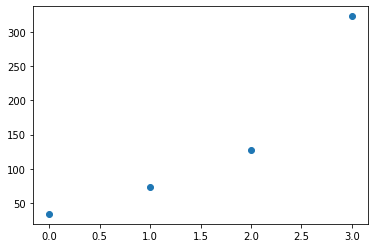

In [8]:
import matplotlib.pyplot as plt
plt.scatter(range(4),[34,73,127,323])
plt.show()

NameError: name 'pd' is not defined